## EXERCISE #1

#1 Imports & Parameters

In [66]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

N = 200_000
rng = np.random.default_rng(42)

We start with an urn containing:
- 3 red balls
- 4 blue balls
- 2 black balls

We then roll a fair dice ONCE:
if the result is:
- a prime number; then we add a black ball
- is 6; then we add a red ball
- is 1 or 4; then we add a blue ball

The next cell will run a vectorized simulation of the amount of independent trials (N) and stores the rolls, p_red (Probability of red each outcome) draw_red (if the ball was red or not)

In [67]:
rolls = rng.integers(1, 7, size=N)

p_red = np.where(
    np.isin(rolls, [2, 3, 5]), 3/10,
    np.where(rolls == 6, 4/10, 3/10)
)

draw_red = rng.random(N) < p_red

draw_red[:10], p_red[:10], rolls[:10]

(array([False, False, False,  True, False, False, False, False,  True,
        False]),
 array([0.3, 0.3, 0.3, 0.3, 0.3, 0.4, 0.3, 0.3, 0.3, 0.3]),
 array([1, 5, 4, 3, 3, 6, 1, 5, 2, 1]))

**Estimating the probability of red using the simulation**

The monte carolo estimate is the sample mean of the red indicator, in which we also report a 95% normal-approximation confidence interval

Monte Carlo estimate P(red) = 0.317490
95% CI ≈ (0.315450, 0.319530)


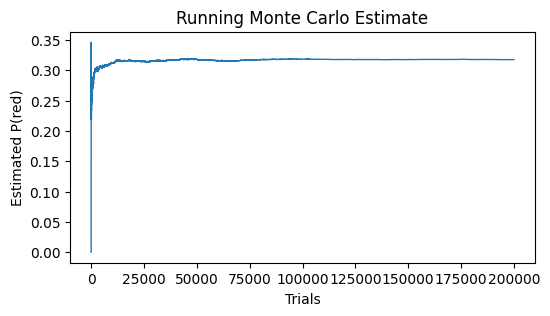

In [68]:
p_hat = draw_red.mean()

se = np.sqrt(p_hat * (1 - p_hat) / N)
ci = (p_hat - 1.96 * se, p_hat + 1.96 * se)

print(f"Monte Carlo estimate P(red) = {p_hat:.6f}")
print(f"95% CI ≈ ({ci[0]:.6f}, {ci[1]:.6f})")

running = np.cumsum(draw_red) / (np.arange(N) + 1)
plt.figure(figsize=(6,3))
plt.plot(running, lw=1)
plt.xlabel("Trials")
plt.ylabel("Estimated P(red)")
plt.title("Running Monte Carlo Estimate")
plt.show()

We condition the die on the outcomes:
 - P(prime) = 3/6, P(red|prime) = 3/10
 - P(6) = 1/6, P(red|6) = 4/10
 - P(other) = 2/6, P(red|other) = 3/10 So
$$
\mathbb{P}(\text{red})
= \mathbb{P}(\text{prime})\,\mathbb{P}(\text{red}\mid\text{prime})
+ \mathbb{P}(6)\,\mathbb{P}(\text{red}\mid 6)
+ \mathbb{P}(\text{other})\,\mathbb{P}(\text{red}\mid\text{other})
= \frac{3}{6}\cdot\frac{3}{10}
+ \frac{1}{6}\cdot\frac{4}{10}
+ \frac{2}{6}\cdot\frac{3}{10}
= \frac{19}{60} \approx 0.316\overline{6}.
$$
And we compare this exact value to the simulation estimate from the previos part.

In [69]:
p_theory = (3/6)*(3/10) + (1/6)*(4/10) + (2/6)*(3/10)
print(f"Theoretical P(red) = {p_theory:.12f}  (= 19/60)")

abs_err = abs(p_hat - p_theory)
print(f"Absolute error |p_hat - p_theory| = {abs_err:.6f}")

Theoretical P(red) = 0.316666666667  (= 19/60)
Absolute error |p_hat - p_theory| = 0.000823


## EXERCISE 2

#1 Imports + Parameters

In [70]:
import numpy as np
import matplotlib.pyplot as plt

N = 1000
rng = np.random.default_rng(42)

Simulating 1000 values from fixed-parameter Poisson distributions which are:
- X1~Poisson(1)
- X2~Poisson(2)
- X3~Poisson(5)
- X4~Poisson(10)

In [71]:
X1 = rng.poisson(lam=1,  size=N)
X2 = rng.poisson(lam=2,  size=N)
X3 = rng.poisson(lam=5,  size=N)
X4 = rng.poisson(lam=10, size=N)

Simulating 1000 values from a randomized Poisson distribution where for each value, picks a lambda that exists within {1,2,5,10} uniformly, and drawing one using that lambda

In [72]:
lambdas = np.array([1, 2, 5, 10])
lam_choices = lambdas[rng.integers(0, len(lambdas), size=N)]
X_rand = rng.poisson(lam=lam_choices)

Plot all the empirical densities and histograms for all the datasets

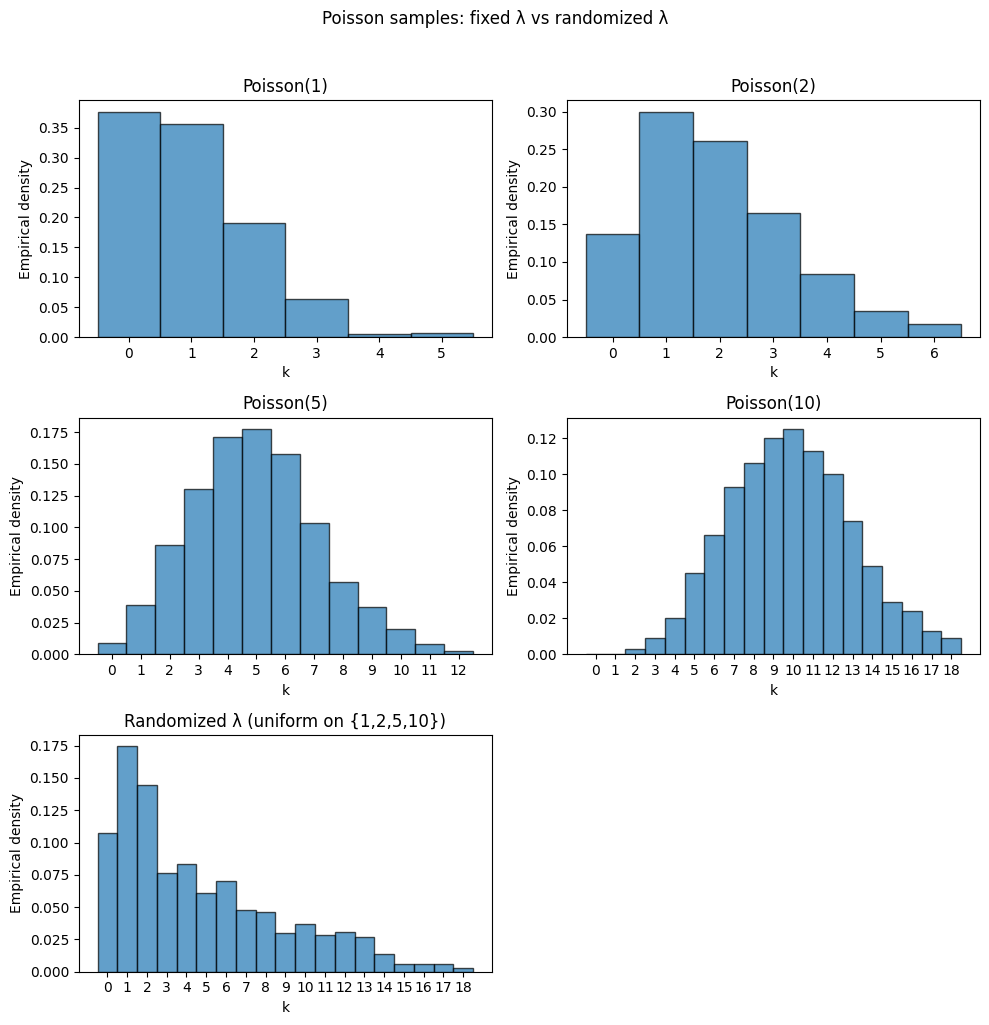

In [73]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.ravel()

datasets = [
    ("Poisson(1)",  X1),
    ("Poisson(2)",  X2),
    ("Poisson(5)",  X3),
    ("Poisson(10)", X4),
    ("Randomized λ (uniform on {1,2,5,10})", X_rand),
]

for ax, (title, data) in zip(axes, datasets + [(" ", np.array([]))]):
    if data.size > 0:
        kmax = int(np.percentile(data, 99.5))
        bins = np.arange(0, kmax + 2) - 0.5
        ax.hist(data, bins=bins, density=True, edgecolor="black", alpha=0.7)
        ax.set_title(title)
        ax.set_xlabel("k")
        ax.set_ylabel("Empirical density")
        ax.set_xticks(np.arange(0, kmax + 1))
    else:
        ax.axis("off")

fig.suptitle("Poisson samples: fixed λ vs randomized λ", y=1.02)
plt.tight_layout()
plt.show()

What if we make 5's probability higher? probabilties will be: {0.2, 0.2, 0.5, 0.1}

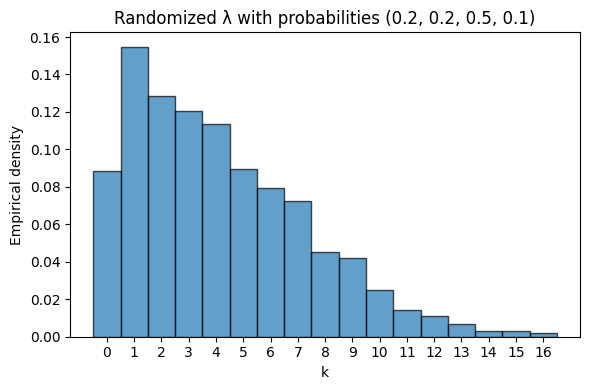

In [74]:
probs = np.array([0.2, 0.2, 0.5, 0.1])
lam_choices_w = rng.choice(lambdas, size=N, p=probs)
X_rand_weighted = rng.poisson(lam=lam_choices_w)

kmax = int(np.percentile(X_rand_weighted, 99.5))
bins = np.arange(0, kmax + 2) - 0.5
plt.figure(figsize=(6,4))
plt.hist(X_rand_weighted, bins=bins, density=True, edgecolor="black", alpha=0.7)
plt.title("Randomized λ with probabilities (0.2, 0.2, 0.5, 0.1)")
plt.xlabel("k")
plt.ylabel("Empirical density")
plt.xticks(np.arange(0, kmax + 1))
plt.tight_layout()
plt.show()
